In [1]:
import pandas as pd
import grafo as gf
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
def extract():
    cruces = pd.read_csv('cruces.csv', sep=';', encoding='latin1')
    direcciones = pd.read_csv('direcciones.csv', sep=';', encoding='latin1')
    direcciones = direcciones[direcciones['Coordenada X (Guia Urbana) cm'] != '000000-100']
    direcciones['Coordenada X (Guia Urbana) cm'] = direcciones['Coordenada X (Guia Urbana) cm'].astype('int64')
    direcciones['Coordenada Y (Guia Urbana) cm'] = direcciones['Coordenada Y (Guia Urbana) cm'].astype('int64')
    return cruces, direcciones

In [3]:
def distance(a,b):
    return np.sqrt((a[0]-b[0])**2 + (a[1]-b[1])**2)

In [4]:
def clean(cruces, direcciones):
    # Quitamos los espacios innecesarios de los datasets
    for df in [cruces, direcciones]:
        for column in df.columns:
            if df[column].dtype == type(object):
                df[column] = df[column].str.strip()
    # En el nombre de las columnas reemplazamos ï¿½ por í usando regex
    direcciones.columns = direcciones.columns.str.replace('ï¿½', 'í')
    direcciones['Direccion'] = direcciones['Codigo de via'].astype(str) + '-' + direcciones['Literal de numeracion'].str.replace('[a-zA-Z. ]', '')
    direcciones.drop_duplicates('Direccion',keep='first',inplace=True)
    direcciones['Nombre completo de calle'] = direcciones['Clase de la via'] + ' ' + direcciones['Partícula de la vía'] + ' ' + direcciones['Nombre de la vía']
    return cruces, direcciones


In [5]:
def unify_vertices(cruces):
    # Ponemos una coordenada común de las glorietas (media de las coordenadas de los cruces)

    # Para empezar nos quedamos con un dataset de las glorietas (solo necesitamos la glorieta como primera via)
    cruces_glorietas = cruces[cruces['Clase de la via tratado'] == 'GLORIETA']
    # Guardamos el número de cruces de cada glorieta en un diccionario, usando value_counts y diferenciando por el código de la vía
    num_cruces = {}
    for glorieta in cruces_glorietas['Codigo de vía tratado'].unique():
        num_cruces[glorieta] = cruces_glorietas['Codigo de vía tratado'].value_counts()[glorieta]
    # Guardamos la suma de las coordenadas (diferenciamos entre X e Y) de los cruces de cada glorieta en un diccionario
    coords_glorietas = {}
    for glorieta in cruces_glorietas['Codigo de vía tratado'].unique():
        coords_glorietas[glorieta] = []
        coords_glorietas[glorieta].append(cruces_glorietas[cruces_glorietas['Codigo de vía tratado'] == glorieta]['Coordenada X (Guia Urbana) cm (cruce)'].sum())
        coords_glorietas[glorieta].append(cruces_glorietas[cruces_glorietas['Codigo de vía tratado'] == glorieta]['Coordenada Y (Guia Urbana) cm (cruce)'].sum())
    # Calculamos la media de las coordenadas de los cruces de cada glorieta
    for glorieta in coords_glorietas:
        coords_glorietas[glorieta][0] = coords_glorietas[glorieta][0] // num_cruces[glorieta]
        coords_glorietas[glorieta][1] = coords_glorietas[glorieta][1] // num_cruces[glorieta]
    # Finalmente, en el dataset de cruces, si hay una glorieta en un cruce, ponemos las coordenadas de la glorieta
    for index, row in cruces.iterrows():
        if row['Clase de la via tratado'] == 'GLORIETA':
            cruces.iloc[index, cruces.columns.get_loc('Coordenada X (Guia Urbana) cm (cruce)')] = coords_glorietas[row['Codigo de vía tratado']][0]
            cruces.iloc[index, cruces.columns.get_loc('Coordenada Y (Guia Urbana) cm (cruce)')] = coords_glorietas[row['Codigo de vía tratado']][1]
        elif row['Clase de la via que cruza'] == 'GLORIETA':
            cruces.iloc[index, cruces.columns.get_loc('Coordenada X (Guia Urbana) cm (cruce)')] = coords_glorietas[row['Codigo de via que cruza o enlaza']][0]
            cruces.iloc[index, cruces.columns.get_loc('Coordenada Y (Guia Urbana) cm (cruce)')] = coords_glorietas[row['Codigo de via que cruza o enlaza']][1]
    return cruces

In [6]:
def select_relevant_info(cruces, direcciones):
    d = direcciones[['Codigo de via', 'Coordenada X (Guia Urbana) cm', 'Coordenada Y (Guia Urbana) cm', 'Direccion']]
    d['tipo'] = ['direcciones' for i in range(len(d))]
    a = []

    for i in d['Direccion'].values:
        i = i.replace('ï¿½', '')
        try:
            a.append(int(i.split('-')[1]))
        except:
            print(i)
    d['Direccion'] = a
    d = d.rename(columns={'Codigo de via': 'codigo'})
    d = d.rename(columns={'Coordenada X (Guia Urbana) cm': 'x'})
    d = d.rename(columns={'Coordenada Y (Guia Urbana) cm': 'y'})

    d = d[d['x'] != '000000-100']
    d['codigo'] = d['codigo'].astype(int)


    d['x'] = d['x'].astype(int)
    d['y'] = d['y'].astype(int)


    c = cruces[['Codigo de vía tratado', 'Coordenada X (Guia Urbana) cm (cruce)', 'Coordenada Y (Guia Urbana) cm (cruce)']]
    c['tipo'] = ['cruces' for i in range(len(c))]

    c = c.rename(columns={'Codigo de vía tratado': 'codigo'})
    c = c.rename(columns={'Coordenada X (Guia Urbana) cm (cruce)': 'x'})
    c = c.rename(columns={'Coordenada Y (Guia Urbana) cm (cruce)': 'y'})
    c['codigo'] = c['codigo'].astype(int)
    c['x'] = c['x'].astype(int)
    c['y'] = c['y'].astype(int)

    # for cruce in c.iterrows():

    # ordenar d por coordenadas y codigo de via

    d = d.sort_values(by=['codigo', 'x', 'y'])

    d['par'] = d['Direccion']%2== 0
    d['par'] = d['par'].astype(int)
    return c, d

In [7]:
def assign_vertices(c, d):
    numeros_cruces = []
    for cruce in c.iterrows():
        d_temp = d[d['codigo'] == cruce[1]['codigo']]
        x, y = cruce[1]['x'], cruce[1]['y']
        distancia_min = 10e10
        num = ''
        n_tot = len(d_temp)
        pares = sum(d_temp['par'])
        d_temp = d_temp[d_temp['par'] == 0] if pares < (n_tot-pares) else d_temp[d_temp['par'] == 1]
        for dir in d_temp.iterrows():
            x1, y1 = dir[1]['x'], dir[1]['y']
            distancia = ((x1 - x)**2 + (y1 - y)**2)**0.5
            distancia_min = min(distancia, distancia_min)
            if distancia_min == distancia:
                num = dir[1]['Direccion']
        numeros_cruces.append(num)
    c['numero'] = numeros_cruces
    c.sort_values(by=['codigo', 'numero'], inplace=True)
    c.reset_index(inplace=True, drop=True)
    with open('cruces_procesado.csv', 'w') as f:
        c.to_csv(f)
    return c

In [8]:
def get_weight(via, origen, destino, type_graph):
    velocidades = {
        'AUTOVIA': 100/60,
        'AVENIDA': 90/60,
        'CARRETERA': 70/60,
        'CALLEJON': 30/60,
        'CAMINO': 30/60,
        'ESTACION': 20/60,
        'PASADIZO': 20/60,
        'PLAZUELA': 20/60,
        'COLONIA': 20/60
    }
    if via not in velocidades:
        vel = 50/60
    else:
        vel = velocidades[via]
    distancia = distance(origen, destino)
    distancia = distancia / 100000
    if type_graph == 'tiempo':
        return distancia/vel
    else:
        return distancia

In [9]:
def create_graph(cruces, c, type_graph):
    G = gf.Grafo(False, {}, [], {})
    id = 1
    last = None
    for idx, row in c.iterrows():
        coords = (row['x'], row['y'])
        if coords in G.vertices_coords:
            vertice_actual = G.vertices_coords[coords]
            vertice_actual.calles.append(row['codigo'])
        else:
            vertice_actual = gf.Vertice(id, [row['codigo']], (row['x'], row['y']))
            G.agregar_vertice(vertice_actual)
        if last:
            if last[1] == row['codigo'] and last[0].coordenadas != coords:
                nombre_calle = cruces[cruces['Codigo de vía tratado'] == row['codigo']]['Literal completo del vial tratado'].values[0]
                data = {'codigo': row['codigo'], 'calle': nombre_calle}
                weight = get_weight(cruces[cruces['Codigo de vía tratado'] == row['codigo']]['Clase de la via tratado'].values[0], last[0].coordenadas, coords, type_graph)
                G.agregar_arista(last[0], vertice_actual, data, weight)
        id += 1
        last = [vertice_actual, row['codigo']]
    return G

In [10]:
def levenshtein(seq1, seq2):
    size_x = len(seq1) + 1
    size_y = len(seq2) + 1
    matrix = np.zeros((size_x, size_y))
    for x in range(size_x):
        matrix [x, 0] = x
    for y in range(size_y):
        matrix [0, y] = y

    for x in range(1, size_x):
        for y in range(1, size_y):
            if seq1[x-1] == seq2[y-1]:
                matrix [x,y] = min(
                    matrix[x-1, y] + 1,
                    matrix[x-1, y-1],
                    matrix[x, y-1] + 1
                )
            else:
                matrix [x,y] = min(
                    matrix[x-1,y] + 1,
                    matrix[x-1,y-1] + 1,
                    matrix[x,y-1] + 1
                )
    return (matrix[size_x - 1, size_y - 1])

In [11]:
def comprobar_direccion(direccion):
    global posibles_calles
    origen_posible = ''
    distancia_str_origen = 10e10
    for calle in posibles_calles:
        dist = levenshtein(calle.lower(), ' '.join(direccion[:-1]))
        if dist < distancia_str_origen:
            distancia_str_origen = dist
            origen_posible = calle
    return origen_posible

In [19]:
def comprobar_numero(numero, direccion):
    global cruces, c, d, direcciones
    # Comprobar que existe el numero de origen
    codigo_direccion = direcciones[direcciones['Nombre completo de calle'] == direccion]['Codigo de via'].values[0]
    c_direccion = c[c['codigo'] == codigo_direccion].reset_index(drop=True)
    d_direccion = direcciones[direcciones['Nombre completo de calle'] == direccion].reset_index(drop=True)
    direccion = direccion + ' ' + numero
    posibles_numeros = set([int(x.split('-')[1]) for x in d_direccion['Direccion']])
    try:
        if int(numero) in posibles_numeros:
            return int(numero), c_direccion, d_direccion, codigo_direccion
    except:
        print('El numero de origen no es valido')
    return None, None, None, None

In [13]:
def instrucciones(camino, G: gf.Grafo):
    instr = ['' for _ in range(len(camino))]
    instr[0] = 'R'
    instr[-1] = 'T'
    for i, node in enumerate(camino[:-1]):
        if instr[i+1] == '':
            if i != len(camino) - 1:
                calle_actual = G.obtener_arista(node, camino[i+1])[0]
                cruces_calle = {x for x in camino if calle_actual in x.calles}
            for j in range(i+1, len(camino)):
                if camino[j] not in cruces_calle:
                    break
            for k in range(i+1, j-1):
                instr[k] = 'R'
            vector1 = np.array([camino[j-1].coordenadas[0]-camino[j-2].coordenadas[0],camino[j-1].coordenadas[1]-camino[j-2].coordenadas[1], 0])
            vector2 = np.array([camino[j].coordenadas[0]-camino[j-1].coordenadas[0],camino[j].coordenadas[1]-camino[j-1].coordenadas[1], 0])
            producto_vectorial = np.cross(vector1, vector2)
            if producto_vectorial[2] > 0:
                instr[j-1] = 'I'
            else:
                instr[j-1] = 'D'
    for i, node in enumerate(camino):
        if instr[i] == 'T':
            print('Ha llegado a su destino')
        elif instr[i] == 'R':
            arista_actual = G.obtener_arista(node, camino[i+1])
            codigo_actual = arista_actual[0]
            calle_actual = arista_actual[1]
            cruces_calle = {x for x in camino if codigo_actual in x.calles}
            for j in range(i+1, len(camino)):
                if camino[j] not in cruces_calle:
                    break
            print(f'Siga recto por la {calle_actual} durante {distance(node.coordenadas, camino[j].coordenadas)//100} metros.')
        elif instr[i] == 'I':
            calle_actual = G.obtener_arista(node, camino[i+1])[1]
            print(f'Gire a la izquierda en la {calle_actual}')
        elif instr[i] == 'D':
            calle_actual = G.obtener_arista(node, camino[i+1])[1]
            print(f'Gire a la derecha en la {calle_actual}')

## MAIN

In [14]:
def main():
    global cruces, direcciones, c, d, posibles_calles
    cruces, direcciones = extract()
    cruces, direcciones = clean(cruces, direcciones)
    cruces = unify_vertices(cruces)
    c, d = select_relevant_info(cruces, direcciones)
    c = assign_vertices(c, d)
    G_time = create_graph(cruces, c, 'tiempo')
    G_distance = create_graph(cruces, c, 'distancia')
    posibles_calles = direcciones['Nombre completo de calle'].unique()
    return cruces, direcciones, c, d, G_time, G_distance, posibles_calles

cruces, direcciones, c, d, G_time, G_distance, posibles_calles = main()

Introduzca las calles de la siguiente manera: Calle X
Siga recto por la CALLE DE FERNANDO EL CATÓLICO durante 109.0 metros.
Gire a la izquierda en la CALLE DE GAZTAMBIDE
Gire a la derecha en la CALLE DE FERNÁNDEZ DE LOS RÍOS
Siga recto por la CALLE DE FERNÁNDEZ DE LOS RÍOS durante 156.0 metros.
Gire a la izquierda en la CALLE DE GUZMÁN EL BUENO
Siga recto por la CALLE DE GUZMÁN EL BUENO durante 174.0 metros.
Gire a la derecha en la CALLE DE JOAQUÍN MARÍA LÓPEZ
Ha llegado a su destino


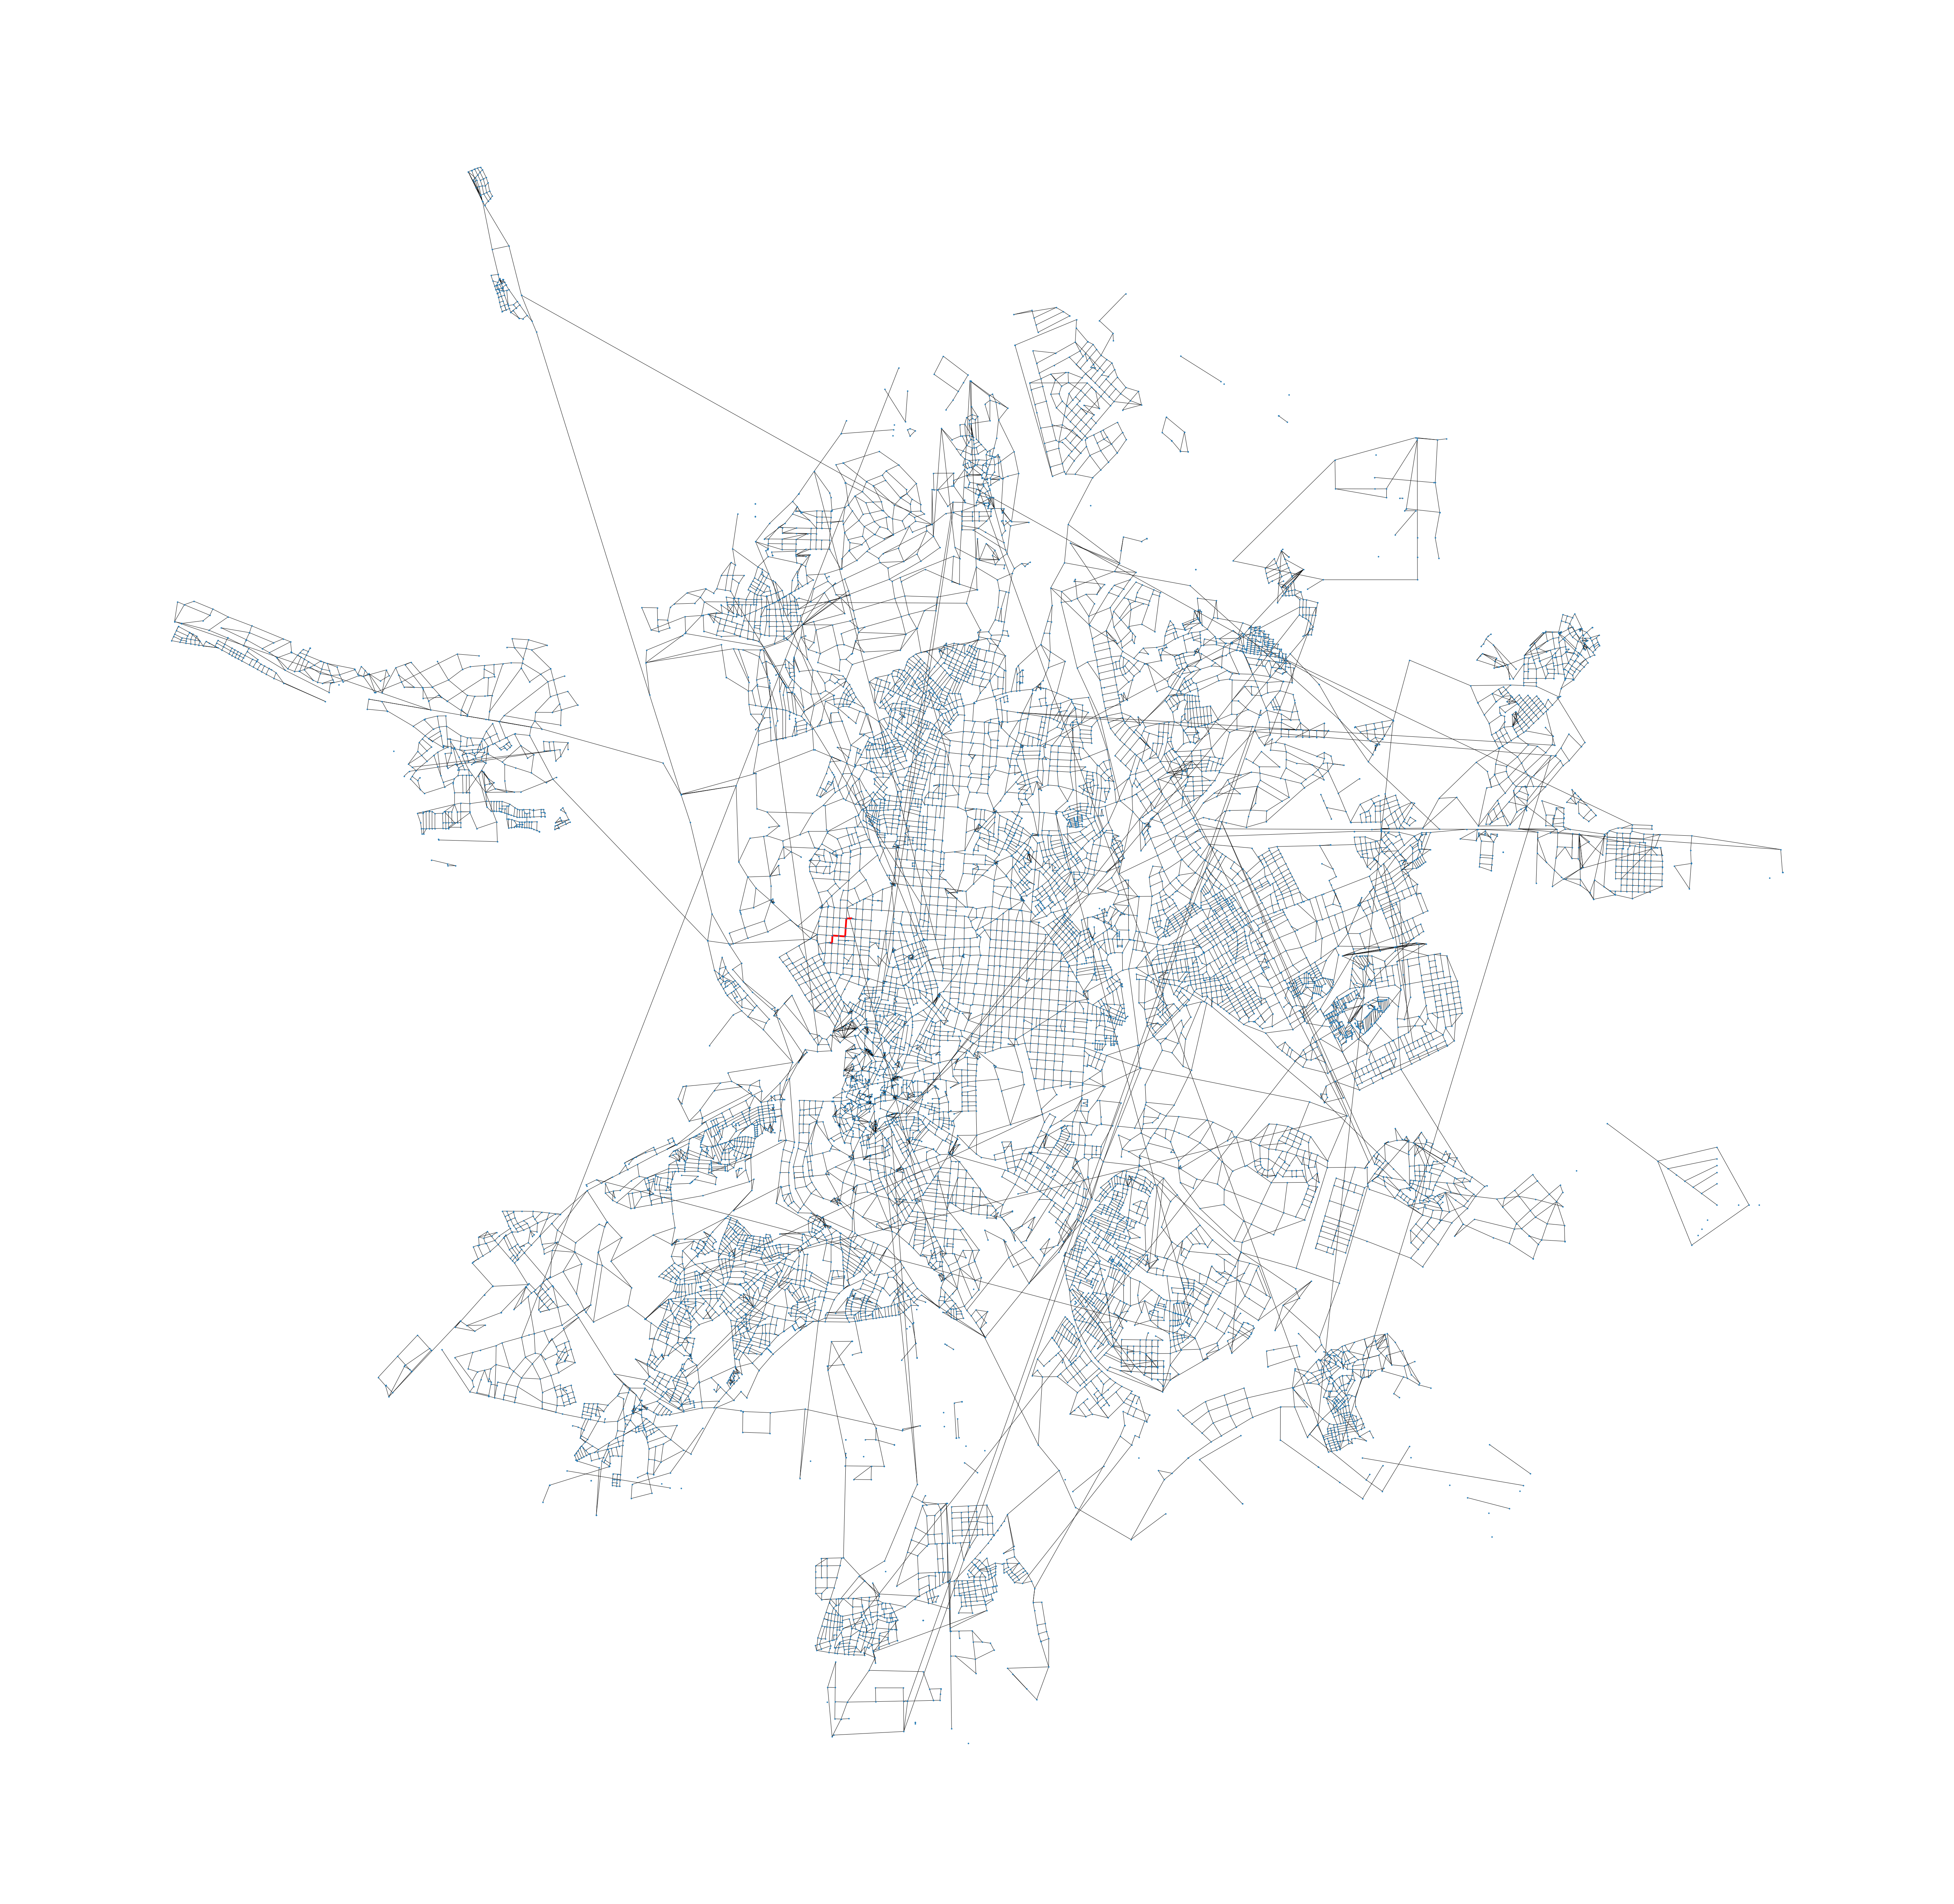

Introduzca las calles de la siguiente manera: Calle X


In [20]:
# 2. Interfaz para elegir calles
end = False
while not end:
    print('Introduzca las calles de la siguiente manera: Calle X')
    origen = input('Elige la dirección de origen: ')
    if len(origen) == 0:
        end = True
        continue
    origen = origen.split(' ')
    numero_origen = origen[-1]
    origen_posible = comprobar_direccion(origen)
    consultar_origen = input('¿Quieres salir de {}? (s/n)'.format(origen_posible))
    while consultar_origen not in ['s', 'n']:
        print('Entrada incorrecta')
        consultar_origen = input('¿Quieres salir de {}? (s/n)'.format(origen_posible))
    if consultar_origen == 'n':
        print('Introduce de nuevo la calle de origen')
        continue
    # Comprobar que existe el numero de origen
    numero_origen, c_origen, d_origen, codigo_origen = comprobar_numero(numero_origen, origen_posible)
    if numero_origen is None:
        print('Introduce de nuevo la calle de origen')
        continue

    destino = input('Elige la dirección de destino: ')
    if len(destino) == 0:
        end = True
        continue
    destino = destino.split(' ')
    numero_destino = destino[-1]
    destino_posible = comprobar_direccion(destino)
    consultar_destino = input('¿Quieres ir a {}? (s/n)'.format(destino_posible))
    while consultar_destino not in ['s', 'n']:
        print('Entrada incorrecta')
        consultar_destino = input('¿Quieres ir a {}? (s/n)'.format(destino_posible))
    if consultar_destino == 'n':
        print('Introduce de nuevo la calle de destino')
        continue
    # Comprobar que existe el numero de destino
    numero_destino, c_destino, d_destino, codigo_destino = comprobar_numero(numero_destino, destino_posible)
    if numero_destino is None:
        print('Introduce de nuevo la calle de destino')
        continue
    
    # Preguntamos que tipo de ruta queremos
    tipo_ruta = input('¿Quieres una ruta corta o rápida? (c/r)')
    while tipo_ruta not in ['c', 'r']:
        print('Entrada incorrecta')
        tipo_ruta = input('¿Quieres una ruta corta o rápida? (c/r)')
    if tipo_ruta == 'c':
        G = G_distance
        type_graph = 'distancia'
    else:
        G = G_time
        type_graph = 'tiempo'

    # crear un nodo en el grafo con el origen conectándolo con los dos nodos más cercanos de su calle
    i1 = i2 = -1
    for i in c_origen.index:
        if c_origen.loc[i, 'numero'] > numero_origen:
            i1 = i - 1
            i2 = i
            break
    aristas_origen = []
    if i1 == -1: 
        aristas_origen.append((c_origen['x'][0], c_origen['y'][0]))
    elif i2 == -1:
        aristas_origen.append((c_origen['x'][-1], c_origen['y'][-1]))
    else:
        aristas_origen.append((c_origen['x'][i1], c_origen['y'][i1]))
        aristas_origen.append((c_origen['x'][i2], c_origen['y'][i2]))
    
    
    # crear un nodo en el grafo con el destino conectándolo con los dos nodos más cercanos de su calle
    j1 = j2 = -1
    for j in c_destino.index:
        if c_destino.loc[j, 'numero'] > numero_destino:
            j1 = j - 1
            j2 = j
            break
    aristas_destino = []
    if j1 == -1: 
        aristas_destino.append((c_destino['x'][0], c_destino['y'][0]))
    elif j2 == -1:
        aristas_destino.append((c_destino['x'][-1], c_destino['y'][-1]))
    else:
        aristas_destino.append((c_destino['x'][j1], c_destino['y'][j1]))
        aristas_destino.append((c_destino['x'][j2], c_destino['y'][j2]))
    
    
    
    d_origen['Numero'] = [x.split('-')[1] for x in d_origen['Direccion']]
    d_origen['Numero'] = d_origen['Numero'].astype(int)
    direcciones_origen = d_origen[d_origen['Numero'] == numero_origen]
    coords_origen = (direcciones_origen['Coordenada X (Guia Urbana) cm'].values[0], direcciones_origen['Coordenada Y (Guia Urbana) cm'].values[0])
    origen_actual = gf.Vertice('O', [codigo_origen], coords_origen)
    G.agregar_vertice(origen_actual)
    nombre_calle = cruces[cruces['Codigo de vía tratado'] == codigo_origen]['Literal completo del vial tratado'].values[0]
    data = {'codigo': codigo_origen, 'calle': nombre_calle}
    for a in aristas_origen:
        weight = get_weight(cruces[cruces['Codigo de vía tratado'] == codigo_origen]['Clase de la via tratado'].values[0], a, coords_origen, type_graph)
        G.agregar_arista(G.vertices_coords[a], origen_actual, data, weight)
    
    d_destino['Numero'] = [x.split('-')[1] for x in d_destino['Direccion']]
    d_destino['Numero'] = d_destino['Numero'].astype(int)
    direcciones_destino = d_destino[d_destino['Numero'] == numero_destino]
    coords_destino = (direcciones_destino['Coordenada X (Guia Urbana) cm'].values[0], direcciones_destino['Coordenada Y (Guia Urbana) cm'].values[0])
    destino_actual = gf.Vertice('D', [codigo_destino], coords_destino)
    G.agregar_vertice(destino_actual)
    nombre_calle = cruces[cruces['Codigo de vía tratado'] == codigo_destino]['Literal completo del vial tratado'].values[0]
    data = {'codigo': codigo_destino, 'calle': nombre_calle}
    for a in aristas_destino:
        weight = get_weight(cruces[cruces['Codigo de vía tratado'] == codigo_destino]['Clase de la via tratado'].values[0], a, coords_destino, type_graph)
        G.agregar_arista(G.vertices_coords[a], destino_actual, data, weight)

    # print(G.vertices_ids)
    camino = G.camino_minimo(origen_actual, destino_actual)
    instrucciones(camino, G)

    G2 = G.convertir_a_NetworkX()
    aam = nx.Graph()
    aam.add_nodes_from([i.id for i in camino])
    aam.add_edges_from([(camino[i].id, camino[i+1].id) for i in range(len(camino)-1)])
    plt.figure(figsize=(100, 100))
    plt.plot()
    pos = {}
    for coords, v in G.vertices_coords.items():
        pos[v.id] = coords
    nx.draw(G2, with_labels=False, pos=pos, node_size=10)
    nx.draw(aam, with_labels=False, pos=pos, node_size=10, edge_color='r', width=5)
    plt.show()


    # Al final del while, debemos borrar tanto las aristas como los nodos creados
    G.eliminar_vertice(origen_actual)
    G.eliminar_vertice(destino_actual)
    for a in aristas_origen:
        G.eliminar_arista(G.vertices_coords[a], origen_actual)
    for a in aristas_destino:
        G.eliminar_arista(G.vertices_coords[a], destino_actual)


